In [145]:
import csv
import os
import sys
import sox
import shutil
from operator import itemgetter
from itertools import groupby
import numpy as np
import seaborn as sns
import shutil 
import pandas as pd
from scipy import stats
import glob
import matplotlib.pyplot as plt
from scipy.stats import ranksums
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from collections import Counter
import re
import spacy
import en_core_web_sm
import glob
from spacy.matcher import Matcher
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from spacy.lang.es.examples import sentences 

In [146]:

import numpy as np
from sklearn import metrics
import sklearn

def kruskal(f, task, c, p, c_name, p_name):
    for i, title in enumerate(task):
        nome = title
        f.write(('\n'+ f'kruskal results for {title} {c_name} {p_name} {stats.kruskal(c[i], p[i]).pvalue} \n\n'))
         

def compute_auc(array_1, array_2):
    xs = np.concatenate([array_1, array_2],axis=1)
    y = np.concatenate([array_1.shape[1]*[2], array_2.shape[1]*[1]])
    
    for i, x in enumerate(xs):
        fpr, tpr, thresholds = metrics.roc_curve(y, x, pos_label=2)
        #print(i, metrics.auc(fpr, tpr))
        m = metrics.roc_auc_score(y, x)
        print(round(max(m, 1-m), 2))


def compute_eta_squared(H, n_of_grp,n_of_observ):
    return (H - n_of_grp + 1)/(n_of_observ - n_of_grp)

In [147]:
def read_stats_test(file):
    
    with open(file, 'r') as f:
        lista = []
        testo = f.readlines()
        testo = [line.strip("\n") for line in testo]

        for line in testo:
            if line=="":
                pass
            else:
                lista.append(line)
                
    return lista
    

In [148]:
def delete_multiple_element(list_object, indices):
    indices = sorted(indices, reverse=True)
    for idx in indices:
        if idx < len(list_object):
            list_object.pop(idx)
            
    return list_object


In [149]:
def holm_correction(kruskal):
    line_to_remove=[]
    values=[]
    corrected =[]
    final = []
    for l in kruskal:
        if "nan" in l:
            line_to_remove.append(kruskal.index(l))
    
    new_krusk = delete_multiple_element(kruskal, line_to_remove)
            
    for line in new_krusk:
        ok = line.split('vs.')[1]
        num = ok.split(" ")[2]
        values.append(float(num))
   # values = [x for x in values if isnan(x) == False]
    result = statsmodels.stats.multitest.fdrcorrection(values, alpha=0.05, method='indep', is_sorted=False)
    num = np.where(result[0] == True)
    list_index = ((num)[0]).tolist()

    for i in list_index:
        corrected.append(result[1][i])
    for i in list_index:
        final.append(kruskal[i])
    
    return final, corrected
    
    
    #return values
#val = np.array(values)
    #return statsmodels.stats.multitest.fdrcorrection(values, alpha=0.05, method='indep', is_sorted=False)

In [150]:
input_dir = '/export/b15/afavaro/Frontiers/Neurovoz_data/Whole_transcr/'
path = []
for ok in os.listdir(input_dir):
    if ok.endswith('.txt'):
        path.append(os.path.join(input_dir, ok))

In [151]:
tasks=[]
label__ =[]
name_id = []
transc = []
for every in path:
    name_id.append(os.path.basename(every).split('-', -1)[0])
    with open(every, "r") as f:
        string_without_line_breaks = ""
        for line in f:
            stripped_line = line.rstrip()
            string_without_line_breaks += stripped_line
            transc.append(string_without_line_breaks)
            every = os.path.basename(every)
            tasks.append(every.split("_")[1])#.split("_")
            label__.append(every.split("_")[0])


In [152]:
df= pd.DataFrame(
    {'idx': name_id, 
     'sentence': transc,
     'label': label__,
     'task': tasks
    })

In [153]:
df['sentence'] = df['sentence'].str.lower()

## Feature Extraction

In [154]:
# Create a function to preprocess the text

#Customized list of stopwords 
nlp = spacy.load("es_core_news_sm")
stopwords = list(stopwords.words('spanish'))

def preprocess(text):
    '''This is a function to perform tokenization, lemmatization, removal of non-alphabetic characters
    and stopword removal'''
  # Create Doc object
    doc = nlp(text, disable=['ner'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha() and lemma not in stopwords]
    return ' '.join(a_lemmas)

In [155]:
df['Item'] = df['sentence'].apply(preprocess)
#df.head()

In [156]:
def count_words(string):
    '''This function returns the number of words in a string'''
    # Split the string into words
    words = string.split()
    # Return the number of words
    return len(words)

df['Word_Count'] = df['sentence'].apply(count_words)

df['Word_Count_No_stop_words'] = df['Item'].apply(count_words)
#df.head()


In [157]:
def word_length(string):
    '''This function returns the average word length in characters for the words in an item'''
    #Get the length of the full text in characters
    chars = len(string)
    #Split the string into words
    words = string.split()
    #Compute the average word length and round the output to the second decimal point
    if len(words)!=0:
        avg_word_length = chars/len(words)
        return round(avg_word_length, 2)
df['Avg_Word_Length'] = df['Item'].apply(word_length)

In [158]:
def sentence_counter(text):
    '''This function returns the number of sentences in an item'''
    doc = nlp(text)
    #Initialize a counter variable
    counter = 0
    #Update the counter for each sentence which can be found in the doc.sents object returned by the Spacy model
    for sentence in doc.sents:
        counter = counter + 1
    return counter

#Note that this function is applied to the raw text in order to identify sentence boundaries

df['Sentence_Count'] = df['sentence'].apply(sentence_counter)
#df.head()

In [159]:
def avg_sent_length(text):
    '''This function returns the average sentence length in an item'''
    doc = nlp(text)
    #Initialize a counter variable
    sent_number = 0
    #Update the counter for each sentence which can be found in the doc.sents object returned by the Spacy model
    for sent in doc.sents:
        sent_number = sent_number + 1
    #Get the number of words
    words = text.split()
    #Compute the average sentence length and round it to the second decimal point
    avg_sent_length = len(words)/sent_number
    return round(avg_sent_length, 2)


df['Avg_Sent_Length_in_Words'] = df['sentence'].apply(avg_sent_length)


In [160]:
def nouns(text, model=nlp):
    '''This function returns the number of nouns in an item'''
    # Create doc object 
    doc = model(text)
    # Generate list of POS tags
    pos = [token.pos_ for token in doc]
    # Return number of nouns
    return pos.count('NOUN')

df['Noun_Count'] = df['Item'].apply(nouns)


In [161]:
def verbs(text, model=nlp):
    '''This function returns the number of verbs in an item'''
    # Create doc object
    doc = model(text)
    # Generate list of POS tags
    pos = [token.pos_ for token in doc]
    # Return number of verbs
    return pos.count('VERB')

df['Verb_Count'] = df['Item'].apply(verbs)

In [162]:
def adjectives(text, model=nlp):
    '''This function returns the number of adjectives in an item'''
    # Create doc object
    doc = model(text)
    # Generate list of POS tags
    pos = [token.pos_ for token in doc]
    # Return number of adjectives
    return pos.count('ADJ')

df['Adjective_Count'] = df['Item'].apply(adjectives)


In [163]:
def adverbs(text, model=nlp):
    '''This function returns the number of adverbs in an item'''
    # Create doc object
    doc = model(text)
    # Generate list of POS tags
    pos = [token.pos_ for token in doc]
    # Return number of adverbs
    return pos.count('ADV')

df['Adverb_Count'] = df['Item'].apply(adverbs)


In [164]:
def numeral(text, model=nlp):
    '''This function returns the number of numerals (e.g., billion) in an item'''
    # Create doc object
    doc = model(text)
    # Generate list of POS tags
    pos = [token.pos_ for token in doc]
    # Return number of adverbs
    return pos.count('NUM')

df['Numeral_Count'] = df['sentence'].apply(numeral) 


In [165]:
def aux(text, model=nlp):
    '''This function returns the number of auxiliary in an item'''
    # Create doc object
    doc = model(text)
    # Generate list of POS tags
    pos = [token.pos_ for token in doc]
    # Return number of adverbs
    return pos.count('AUX')

df['Auxiliary_Count'] = df['sentence'].apply(aux) #meglio estrarlo dall'originale
#df.head()

In [166]:
def get_nps(text):
    '''This is a function that outputs the number of noun phrases in an item'''
    doc = nlp(text)
    NP_count = 0
    for np in doc.noun_chunks:
        NP_count = NP_count + 1
    return NP_count
    #print(np)

df['Number_of_NPs'] = df['Item'].apply(get_nps)
#df.head()

In [167]:
def get_pps(text):
    '''This is a function that outputs the number of prepositional phrases in an item'''
    doc = nlp(text)
    pps = 0
    for token in doc:
        # You can try this with other parts of speech for different subtrees.
        if token.pos_ == 'ADP':
            
            #Use the command below if you wanted to get the actual PPs
            #pp = ' '.join([tok.orth_ for tok in token.subtree])
            
            #This command counts the number of PPs
            pps = pps + 1
            
    return pps

df['Number_of_PPs'] = df['Item'].apply(get_pps)
#df.head()

In [168]:
pattern = [{'POS': 'VERB', 'OP': '?'},
           {'POS': 'ADV', 'OP': '*'},
           {'POS': 'AUX', 'OP': '*'},
           {'POS': 'VERB', 'OP': '+'}]


def get_vps(text):
    '''This function returns the number of verb phrases in an item'''
    doc = nlp(text)
    vps = 0
    # instantiate a Matcher instance
    matcher = Matcher(nlp.vocab)
    matcher.add("Verb phrase", [pattern], on_match=None) #new syntax of the command
    # call the matcher to find matches 
    matches = matcher(doc)
    spans = [doc[start:end] for _, start, end in matches]
    for match in matches:
        vps = vps +1
    return vps
    
df['Number_of_VPs'] = df['Item'].apply(get_vps)


In [169]:
def informational_verb(text):
    
    '''Exhaustivness of the description operationalized by 
    counting how many (if any) salient items (nouns) are mentioned. '''
    
    cont_con = 0
    
    if "lavando" in text:
        cont_con = cont_con + 1
        
    if "lavar" in text:
        cont_con = cont_con + 1
        
    if "barrer" in text:
        cont_con = cont_con + 1
    
    if "barriendo" in text:
        cont_con = cont_con + 1
      
    if "ducharse" in text:
        cont_con = cont_con + 1
        
    if "bañarse" in text:
        cont_con = cont_con + 1
    
    if "duchandose" in text:
        cont_con = cont_con + 1
        
    if "lavandose" in text:
        cont_con = cont_con + 1

    if "pesar" in text:
        cont_con = cont_con + 1
        
    if "pesando" in text:
        cont_con = cont_con + 1
        
    if "duchando" in text:
        cont_con = cont_con + 1

    return cont_con

df['informational_verb'] = df['sentence'].apply(informational_verb)

In [126]:
#df.to_csv("/export/b15/afavaro/Frontiers/submission/Statistical_Analysis/NEUROVOZ/ling_data_with_events.csv")

In [170]:
task_grouped_ = df.groupby('task')
concatenateread = task_grouped_.get_group("concatenateread")
ESPONTANEA = task_grouped_.get_group("ESPONTANEA")

## Monologue

In [171]:
grouped = ESPONTANEA.groupby('label')
control = grouped.get_group("HC") 
parkinson_ = grouped.get_group("PD")
task = ESPONTANEA.columns[5:-1].values.tolist()
PD_all_feat = np.array([parkinson_[feat] for feat in np.array(ESPONTANEA.columns[5:-1])])
CN_all_feat = np.array([control[feat] for feat in np.array(ESPONTANEA.columns[5:-1])])


with open('/export/b15/afavaro/Frontiers/submission/SPANISH/LINGUISTIC/Results/cd_pd_espontanea.txt', 'w') as f:
 
    kruskal(f, task, CN_all_feat,  PD_all_feat, "controls vs.", "parkinson")
    
kruskal_1 = read_stats_test('/export/b15/afavaro/Frontiers/submission/SPANISH/LINGUISTIC/Results/cd_pd_espontanea.txt')
holm_correction(kruskal_1)
    

(['kruskal results for Word_Count controls vs. parkinson 0.00545558570248233 ',
  'kruskal results for Word_Count_No_stop_words controls vs. parkinson 0.008708228249670063 ',
  'kruskal results for Sentence_Count controls vs. parkinson 0.0002551384817388585 ',
  'kruskal results for Noun_Count controls vs. parkinson 0.007871536283856437 ',
  'kruskal results for Verb_Count controls vs. parkinson 0.0008057789546427356 ',
  'kruskal results for Auxiliary_Count controls vs. parkinson 0.007628355233504417 ',
  'kruskal results for Number_of_NPs controls vs. parkinson 0.002938757954008111 ',
  'kruskal results for Number_of_VPs controls vs. parkinson 0.008545195431261917 '],
 [0.01523939943692261,
  0.01523939943692261,
  0.0035719387443440193,
  0.01523939943692261,
  0.005640452682499149,
  0.01523939943692261,
  0.013714203785371186,
  0.01523939943692261])

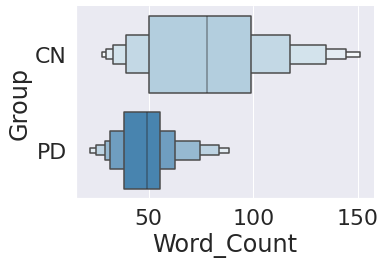

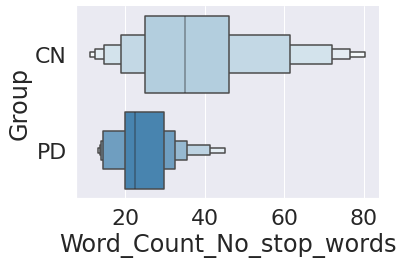

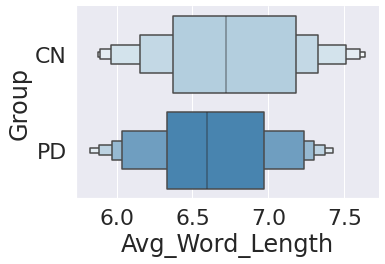

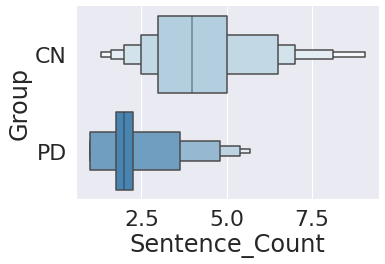

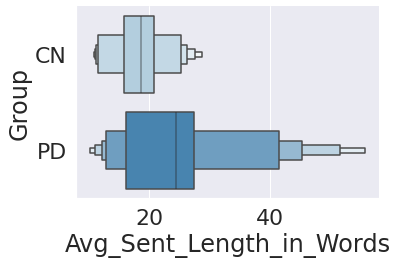

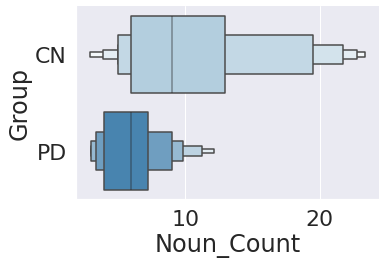

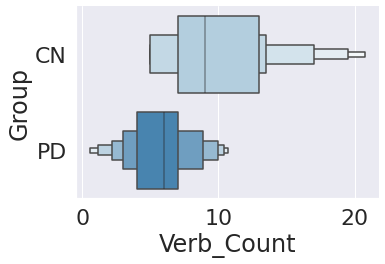

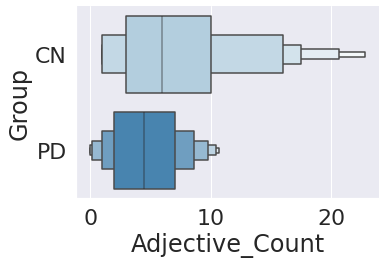

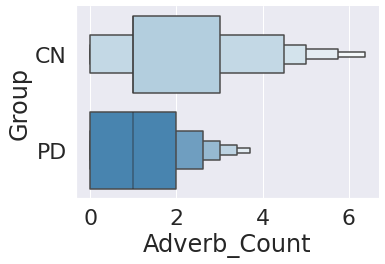

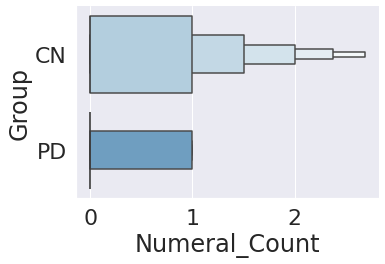

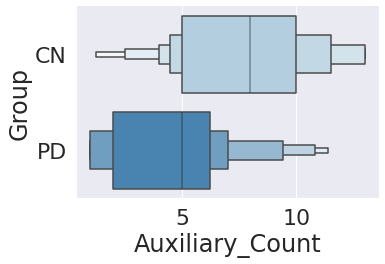

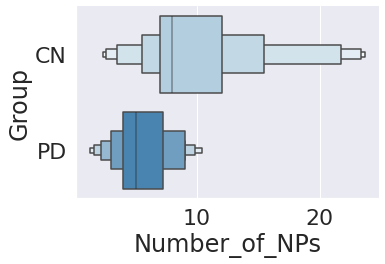

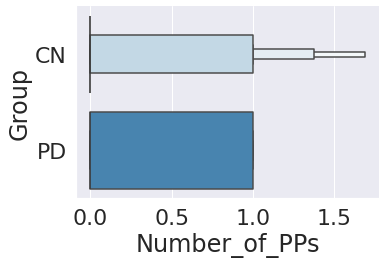

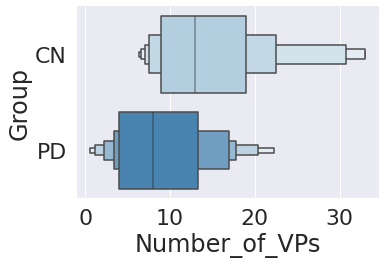

In [172]:
for i, title in enumerate(task):  
    
    nome = title
   
    controls = []
    parkinson=[]
    
    data = np.concatenate([CN_all_feat[i], PD_all_feat[i]])
    data = data.tolist()
    data = [float(x) for x in data if x != "None"]


    [controls.append('CN') for value in range(len(CN_all_feat[i]))]
   
    [parkinson.append('PD') for value in range(len(PD_all_feat[i]))]
   
    lista = controls+parkinson
    
    dict = {nome: data, 'Group': lista} 
    df = pd.DataFrame(dict)
    #tips = pd.DataFrame()
    #tips['task'] = data
    #tips['lista'] = lista
    
    sns.set(font_scale=2)
    sns.catplot(x=nome, y="Group", kind="boxen", data=df, k_depth='full', palette="Blues",\
               height=4.2, aspect=1.4, showfliers = False)
    
   # plt.savefig(f'/export/b15/afavaro/Frontiers/submission/SPANISH/LINGUISTIC/Plots/{nome}.png', facecolor='white', dpi=600)